Possible flight actions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Possible aircraft actions: [0, 1, 2, 3]
│ Target Aircraft    │ Target Flight      │ Current Time       │ Time Until End     │
│          0         │         990        │          -         │          -         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1   135   352 |     2   406   525 |     3   536   604 |     4   715   893 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     5   270   437 |     6   476   562 |     7   655   725 |     8   875  1027 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     - 

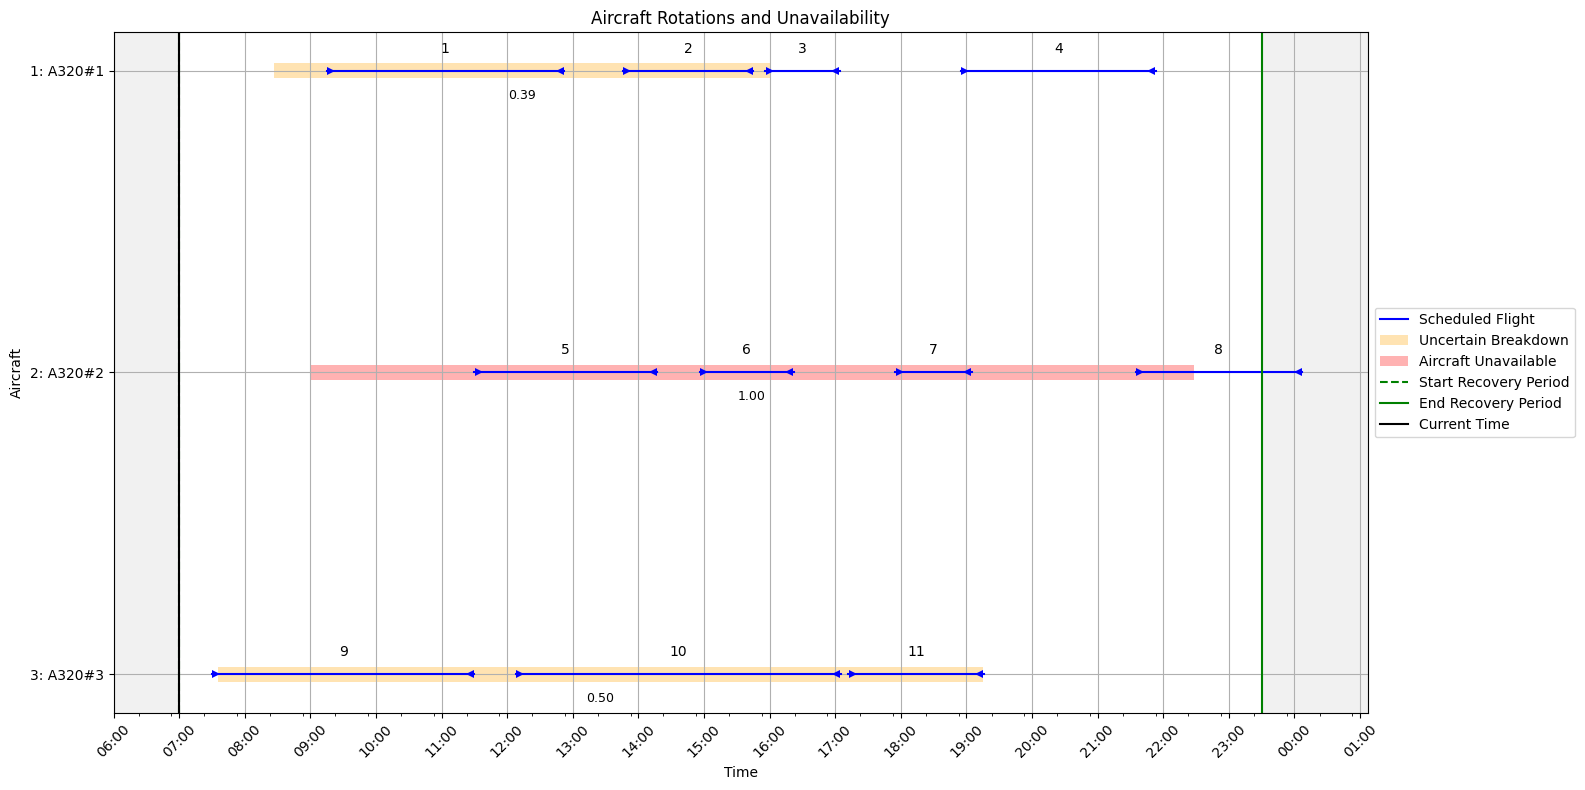

Action index: 0
Chosen action: flight 0, aircraft 0
Current datetime: 2024-09-23 07:00:00
Rolling the dice for breakdown with initial probability 0.5 starting at 2024-09-23 07:36:00
Breakdown confirmed for aircraft A320#3 with probability 0.5
│ Current Time       │ Time Until End     │   
│          0         │         990        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1   135   352 |     2   406   525 |     3   536   604 |     4   715   893 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     5   270   437 |     6   476   562 |     7   655   725 |     8   875  1027 |     -     -     - |     -   

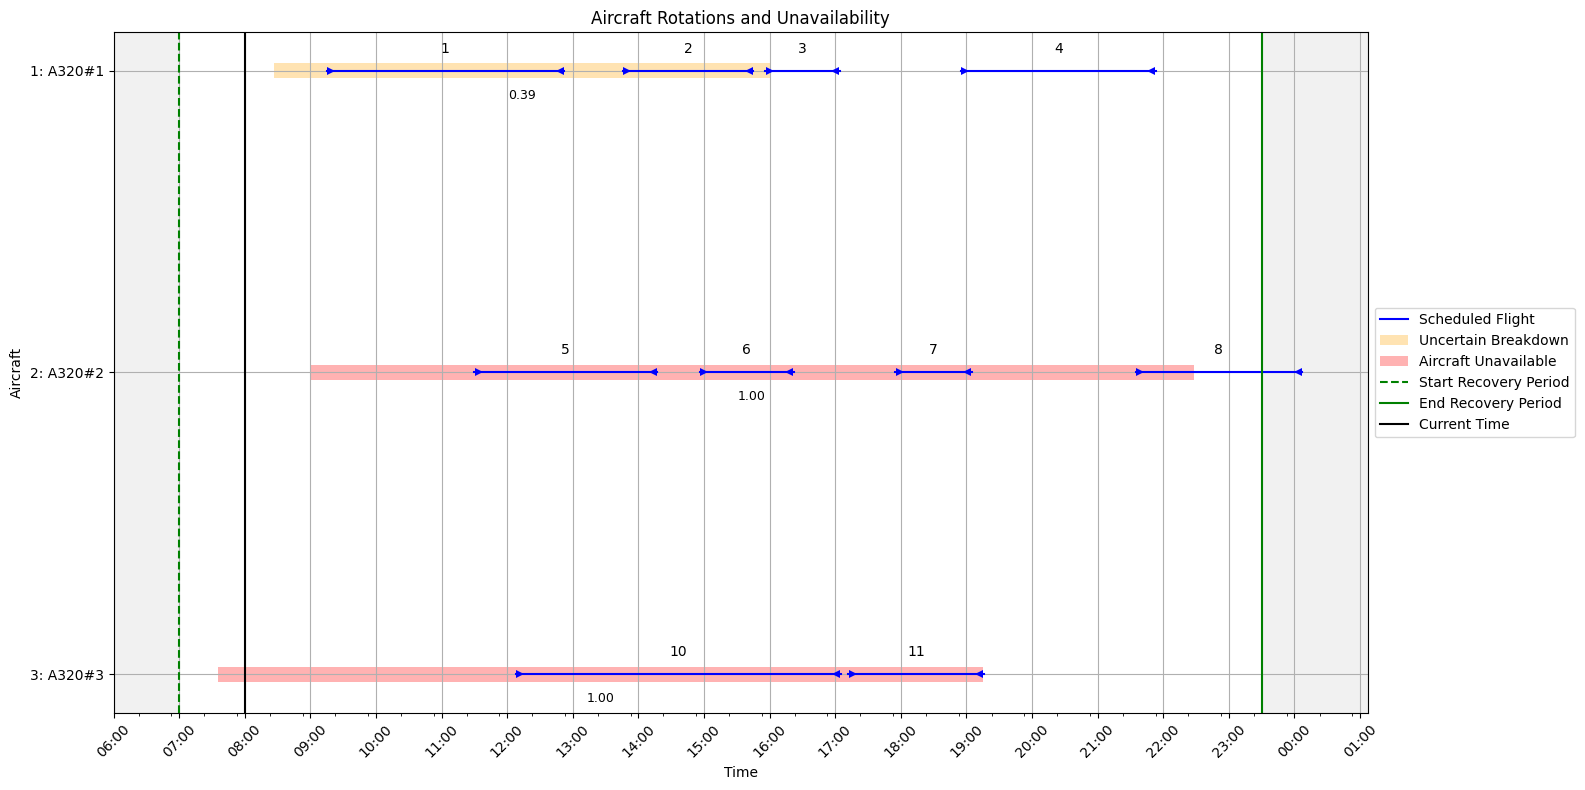

Action index: 15
Chosen action: flight 3, aircraft 3
Current datetime: 2024-09-23 08:00:00
Rolling the dice for breakdown with initial probability 0.39 starting at 2024-09-23 08:27:00
Breakdown not occurring for aircraft A320#1
│ Current Time       │ Time Until End     │   
│         60         │         930        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1   135   352 |     2   406   525 |     3   536   604 |     4   715   893 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     5   270   437 |     6   476   562 |     7   655   725 |     8   875  1027 |     -     -     - |     -     -     - |    

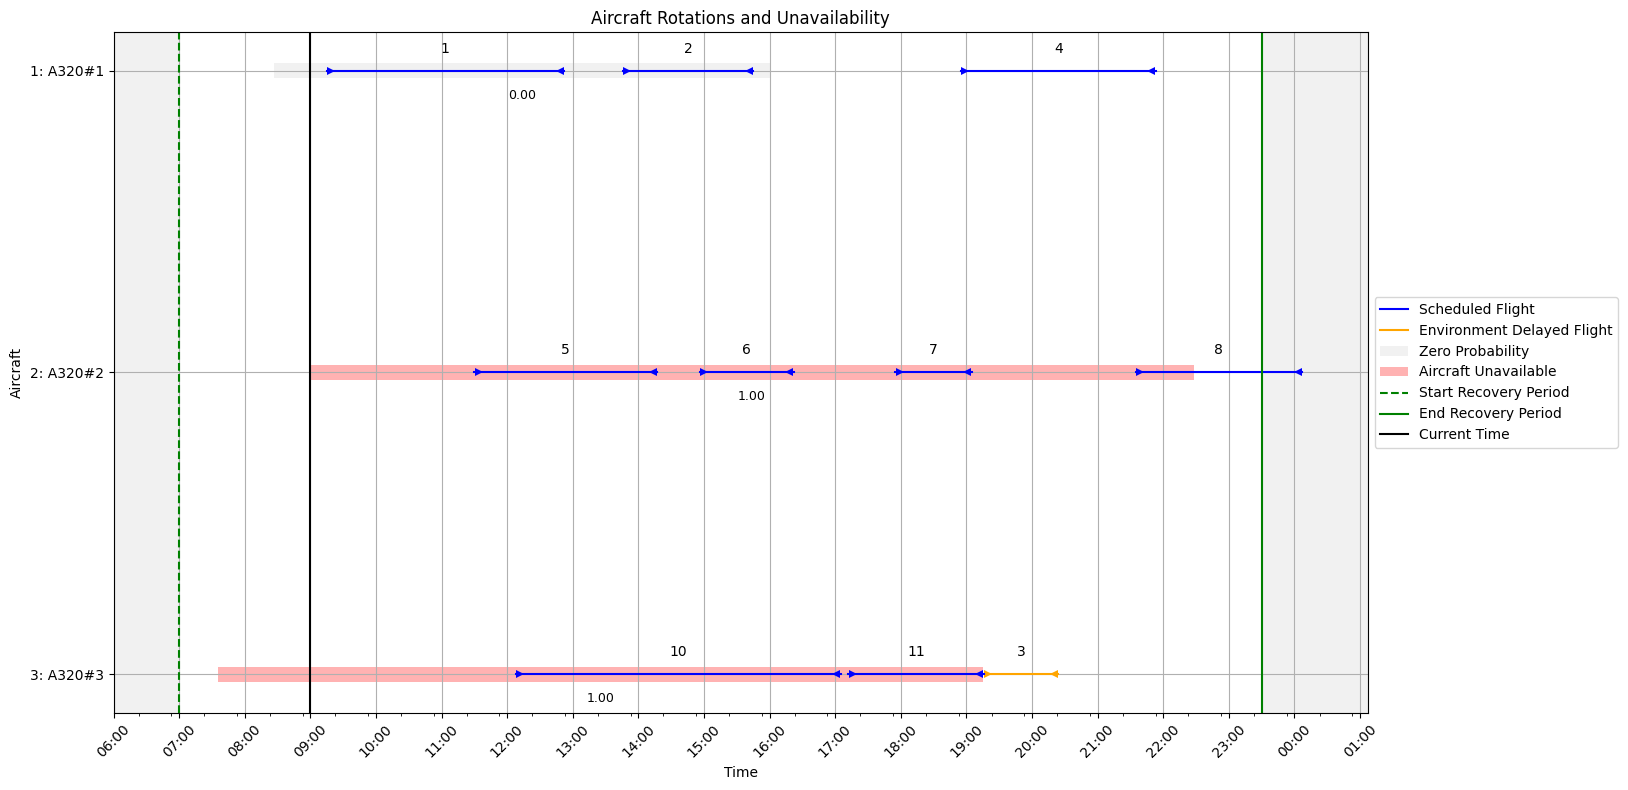

Action index: 21
Chosen action: flight 5, aircraft 1
Current datetime: 2024-09-23 09:00:00
│ Current Time       │ Time Until End     │   
│         120        │         870        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1   135   352 |     2   406   525 |     4   715   893 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     5   270   437 |     6   476   562 |     7   655   725 |     8   875  1027 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00     36   7

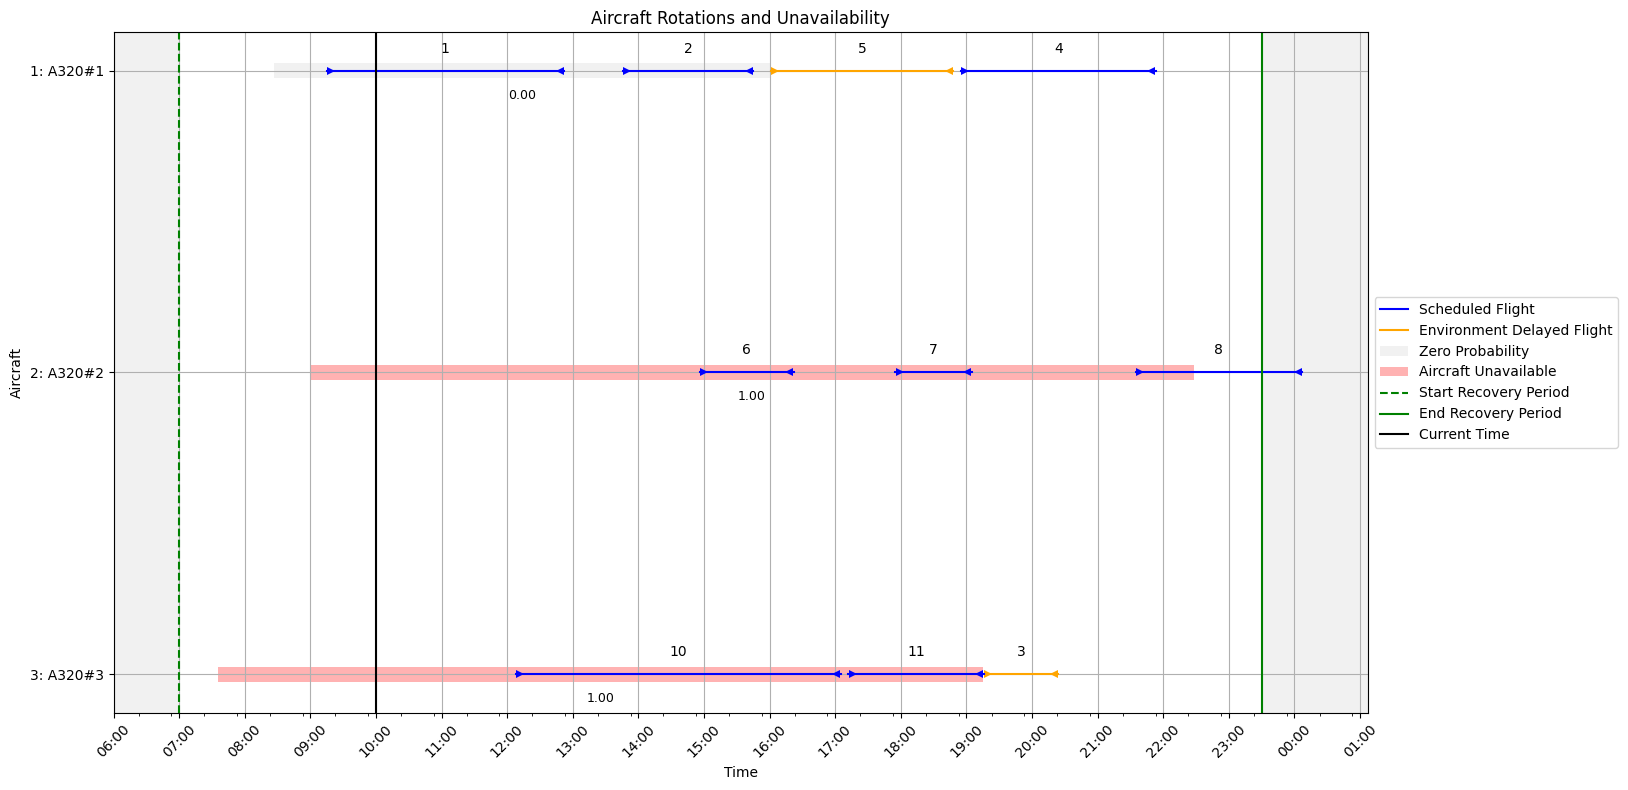

Action index: 27
Chosen action: flight 6, aircraft 3
Current datetime: 2024-09-23 10:00:00
│ Current Time       │ Time Until End     │   
│         180        │         810        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1   135   352 |     2   406   525 |     5   541   708 |     4   715   893 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     6   476   562 |     7   655   725 |     8   875  1027 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00     36   7

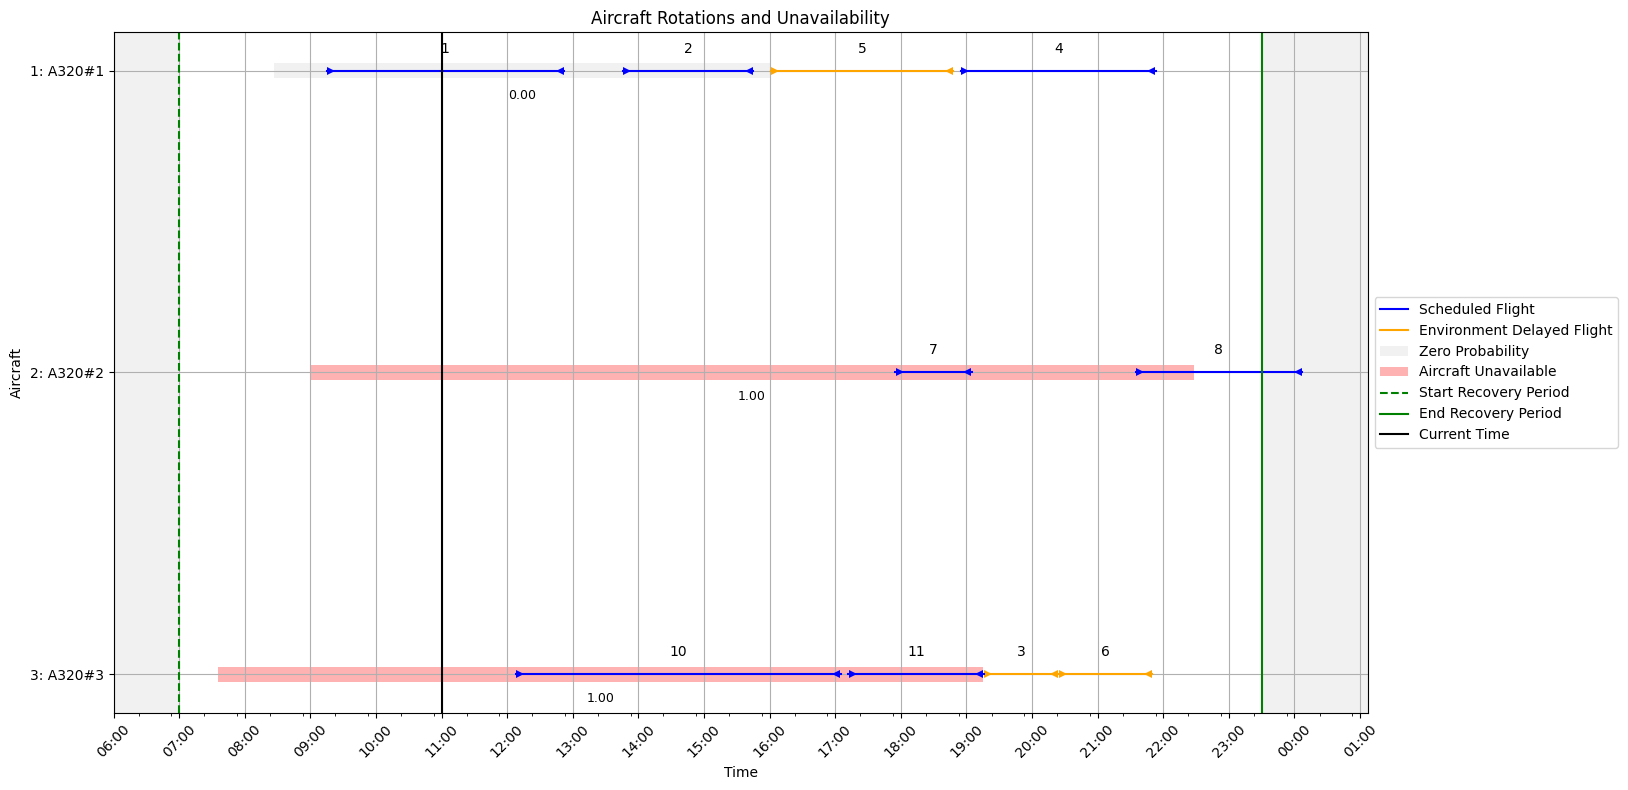

Action index: 5
Chosen action: flight 1, aircraft 1
Current datetime: 2024-09-23 11:00:00
│ Current Time       │ Time Until End     │   
│         240        │         750        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1   135   352 |     2   406   525 |     5   541   708 |     4   715   893 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     7   655   725 |     8   875  1027 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00     36   73

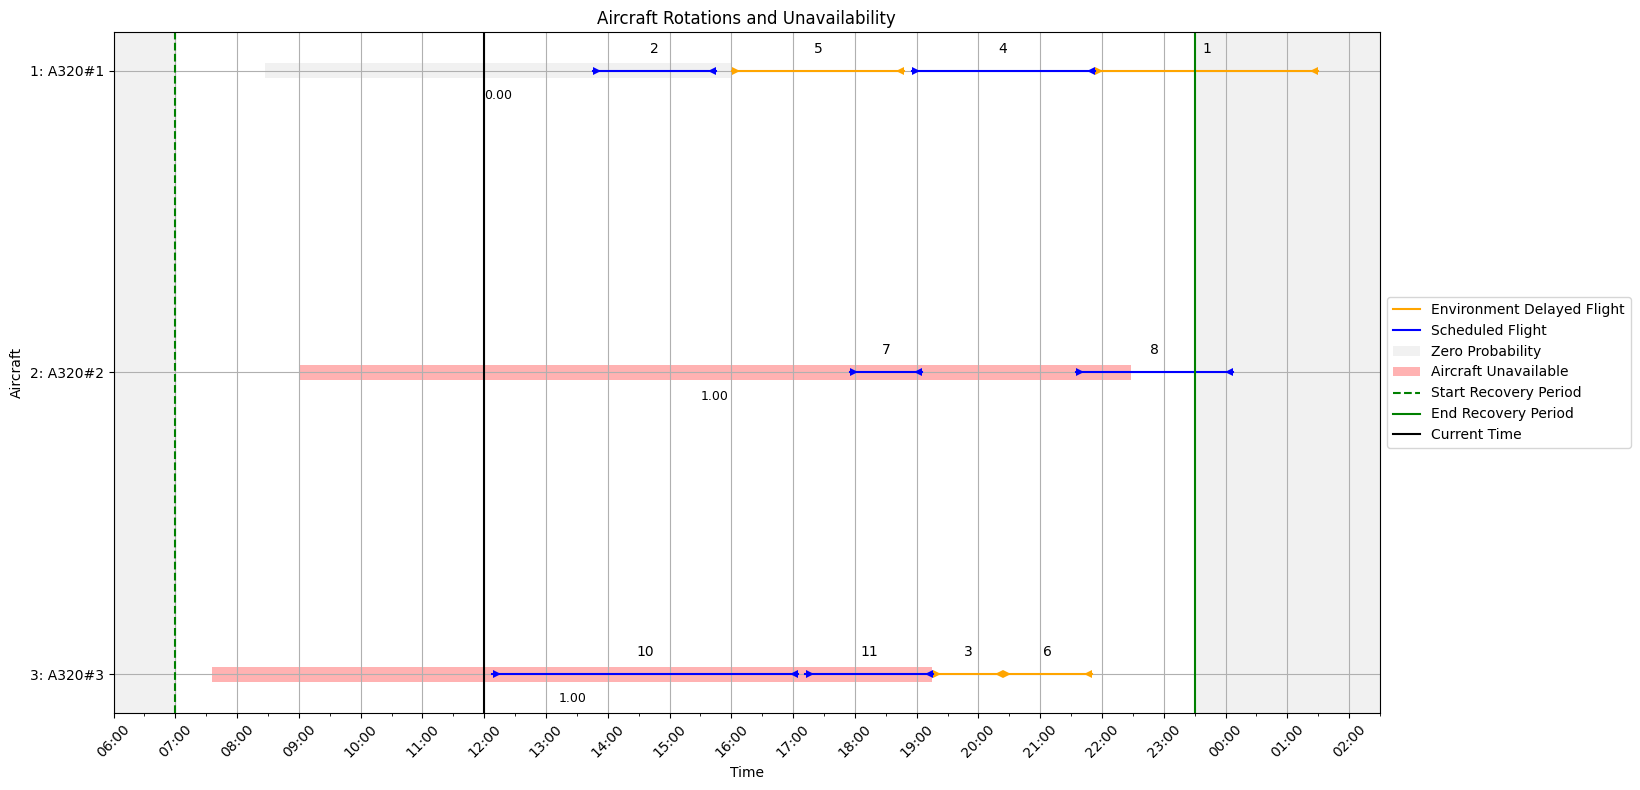

Action index: 47
Chosen action: flight 11, aircraft 3
Current datetime: 2024-09-23 12:00:00
│ Current Time       │ Time Until End     │   
│         300        │         690        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     2   406   525 |     5   541   708 |     4   715   893 |     1   893  1110 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     7   655   725 |     8   875  1027 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00     36   

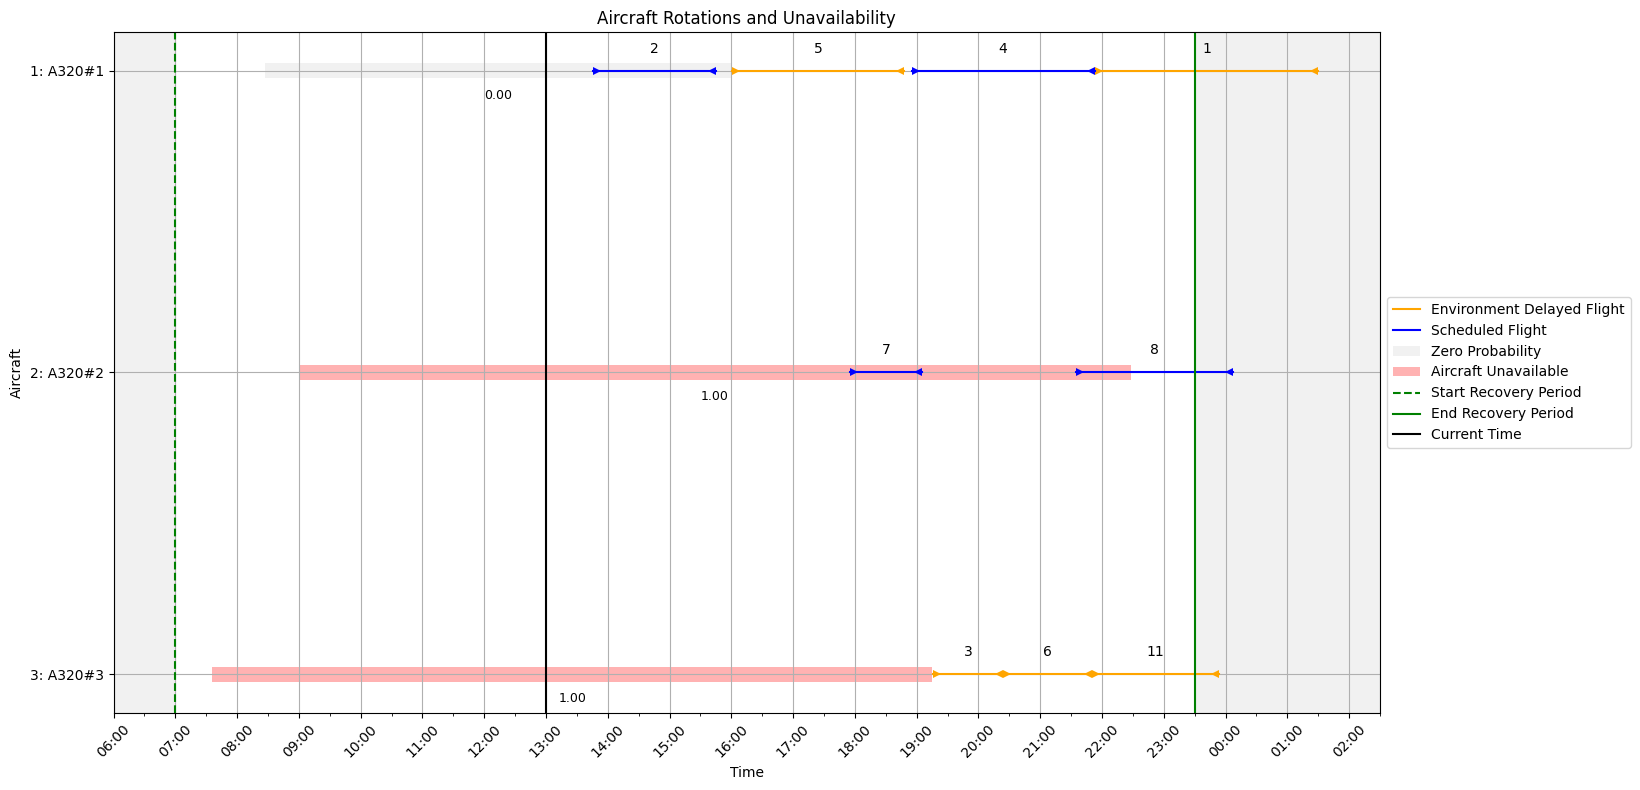

Action index: 46
Chosen action: flight 11, aircraft 2
Current datetime: 2024-09-23 13:00:00
│ Current Time       │ Time Until End     │   
│         360        │         630        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     2   406   525 |     5   541   708 |     4   715   893 |     1   893  1110 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     7   655   725 |     8   875  1027 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00     36   

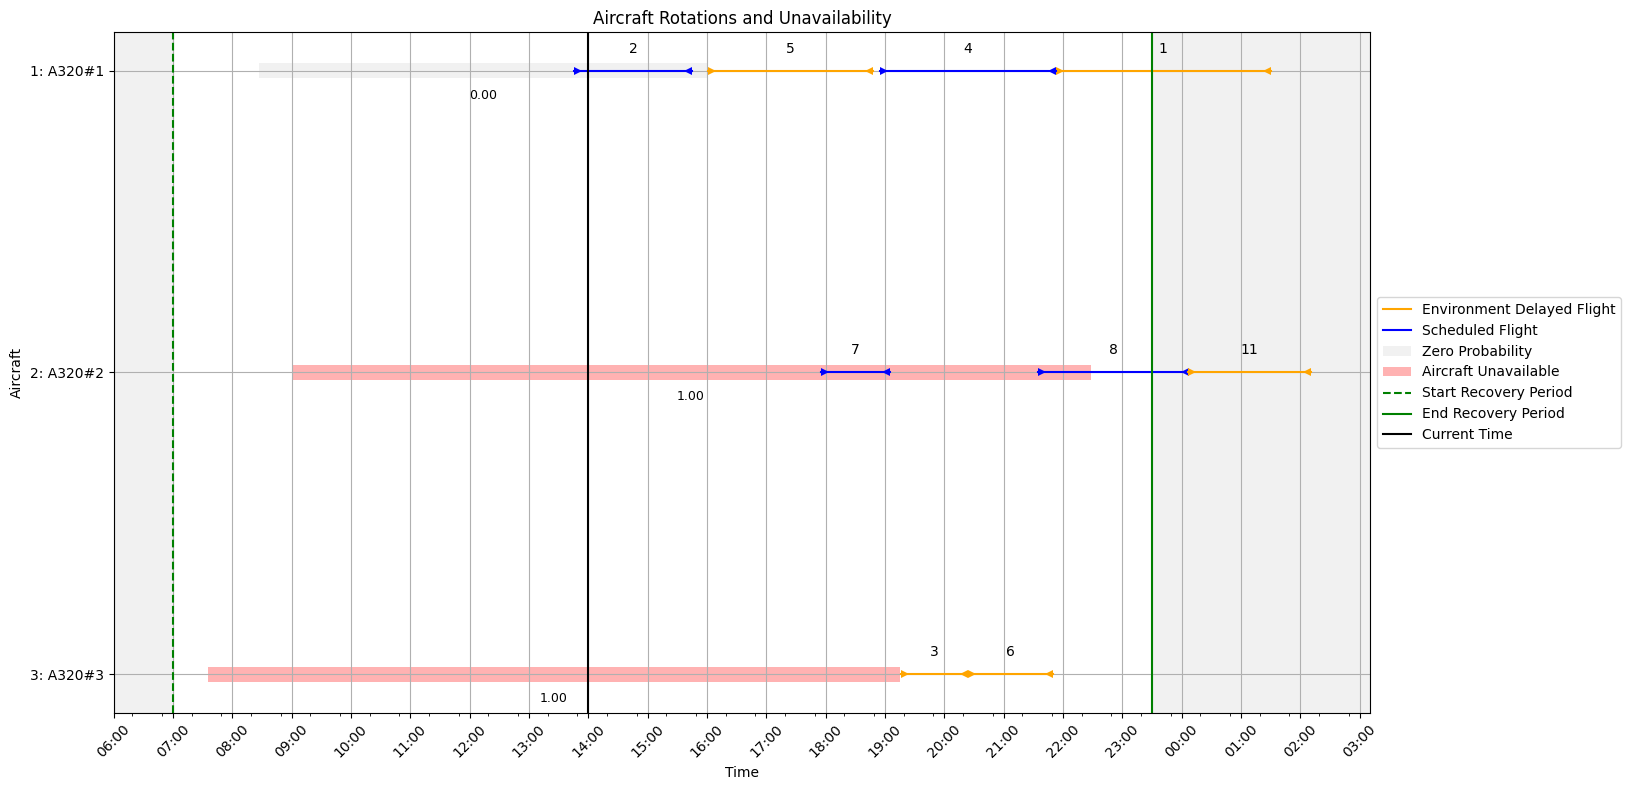

Action index: 2
Chosen action: flight 0, aircraft 2
Current datetime: 2024-09-23 14:00:00
│ Current Time       │ Time Until End     │   
│         420        │         570        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     2   406   525 |     5   541   708 |     4   715   893 |     1   893  1110 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     7   655   725 |     8   875  1027 |    11  1027  1151 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00     36   73

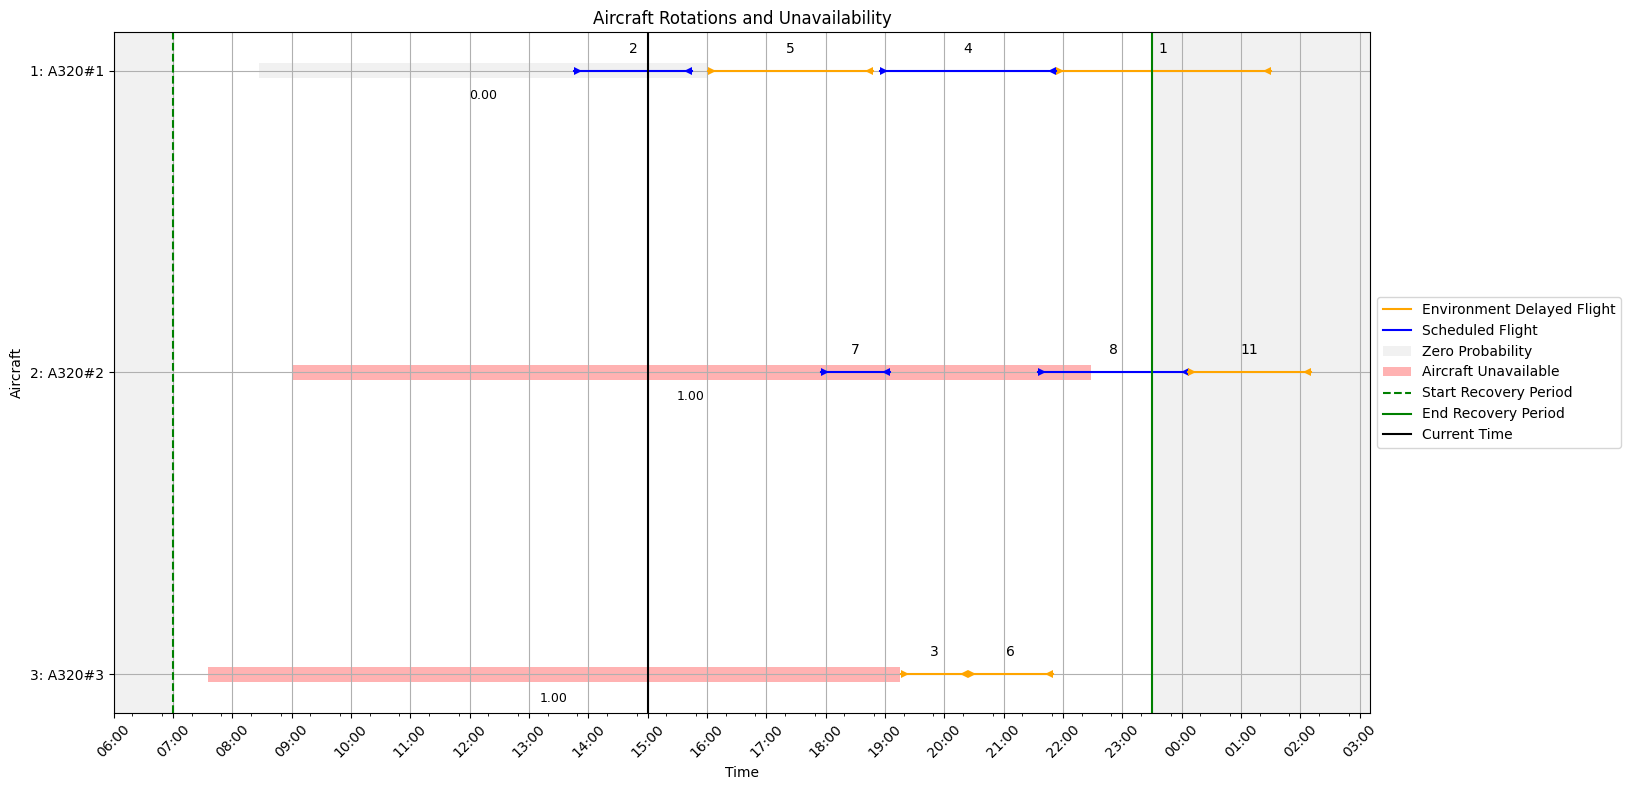

Action index: 6
Chosen action: flight 1, aircraft 2
Current datetime: 2024-09-23 15:00:00
│ Current Time       │ Time Until End     │   
│         480        │         510        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     2   406   525 |     5   541   708 |     4   715   893 |     1   893  1110 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     7   655   725 |     8   875  1027 |    11  1027  1151 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00     36   73

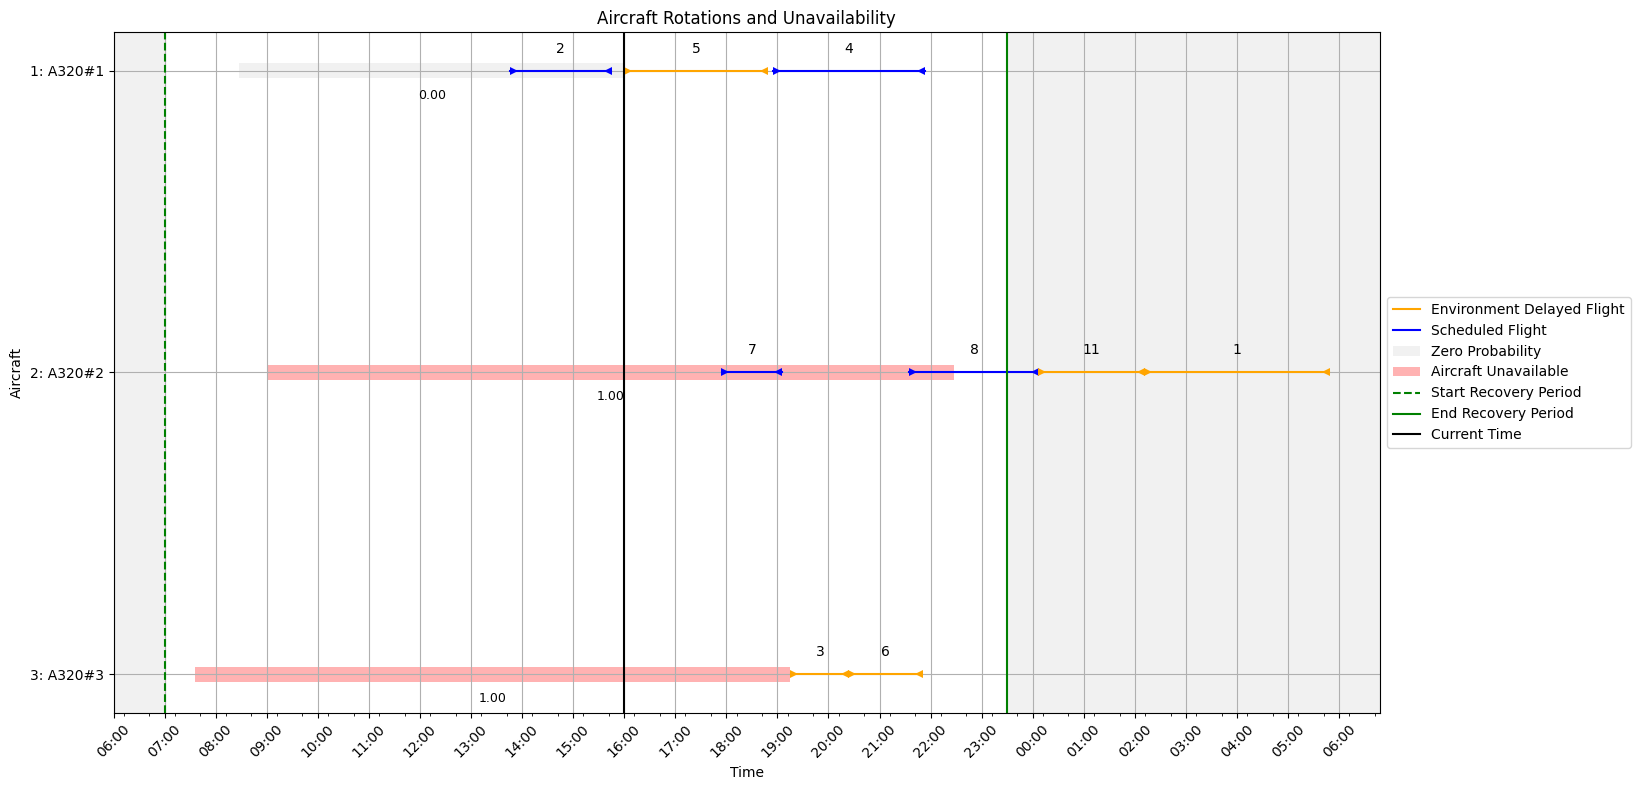

Action index: 13
Chosen action: flight 3, aircraft 1
Current datetime: 2024-09-23 16:00:00
│ Current Time       │ Time Until End     │   
│         540        │         450        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     2   406   525 |     5   541   708 |     4   715   893 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     7   655   725 |     8   875  1027 |    11  1027  1151 |     1  1151  1368 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00     36   7

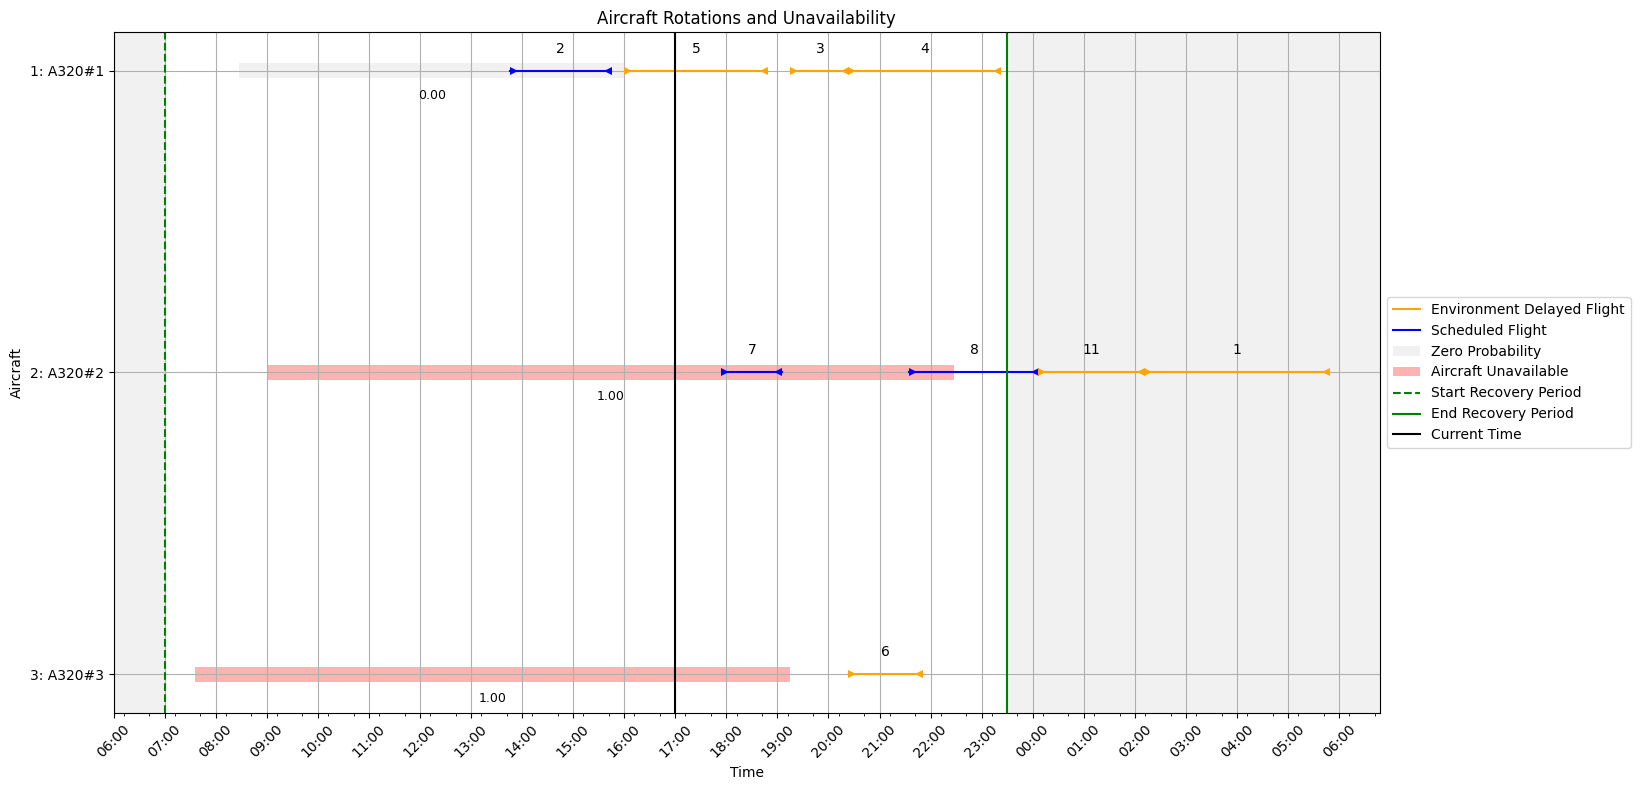

Action index: 6
Chosen action: flight 1, aircraft 2
Current datetime: 2024-09-23 17:00:00
│ Current Time       │ Time Until End     │   
│         600        │         390        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     2   406   525 |     5   541   708 |     3   736   804 |     4   804   982 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     7   655   725 |     8   875  1027 |    11  1027  1151 |     1  1151  1368 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00     36   73

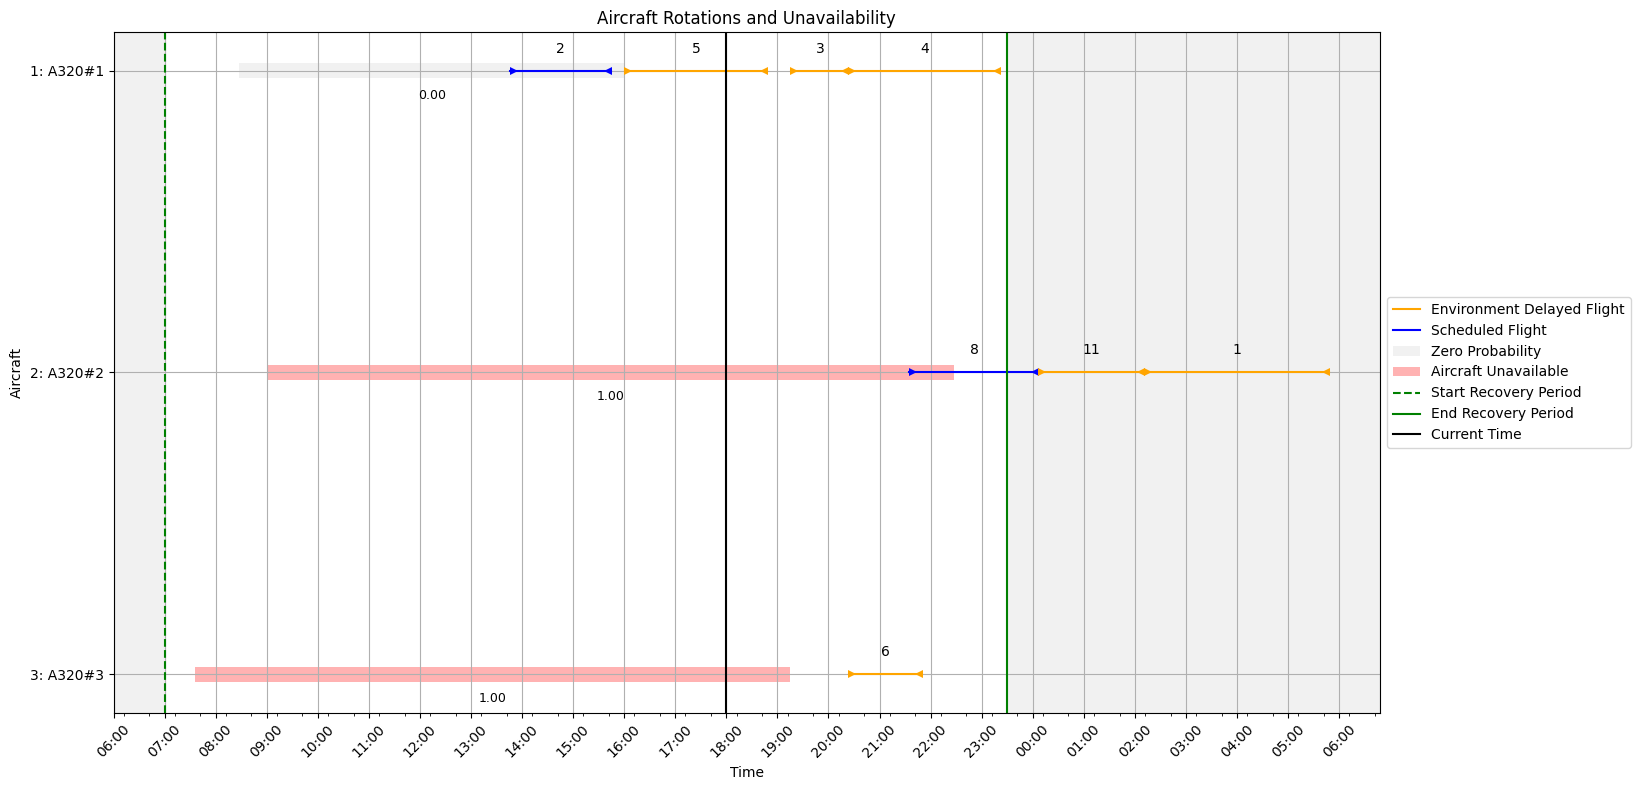

Action index: 35
Chosen action: flight 8, aircraft 3
Current datetime: 2024-09-23 18:00:00
│ Current Time       │ Time Until End     │   
│         660        │         330        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     2   406   525 |     5   541   708 |     3   736   804 |     4   804   982 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    120   928 |     8   875  1027 |    11  1027  1151 |     1  1151  1368 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00     36   7

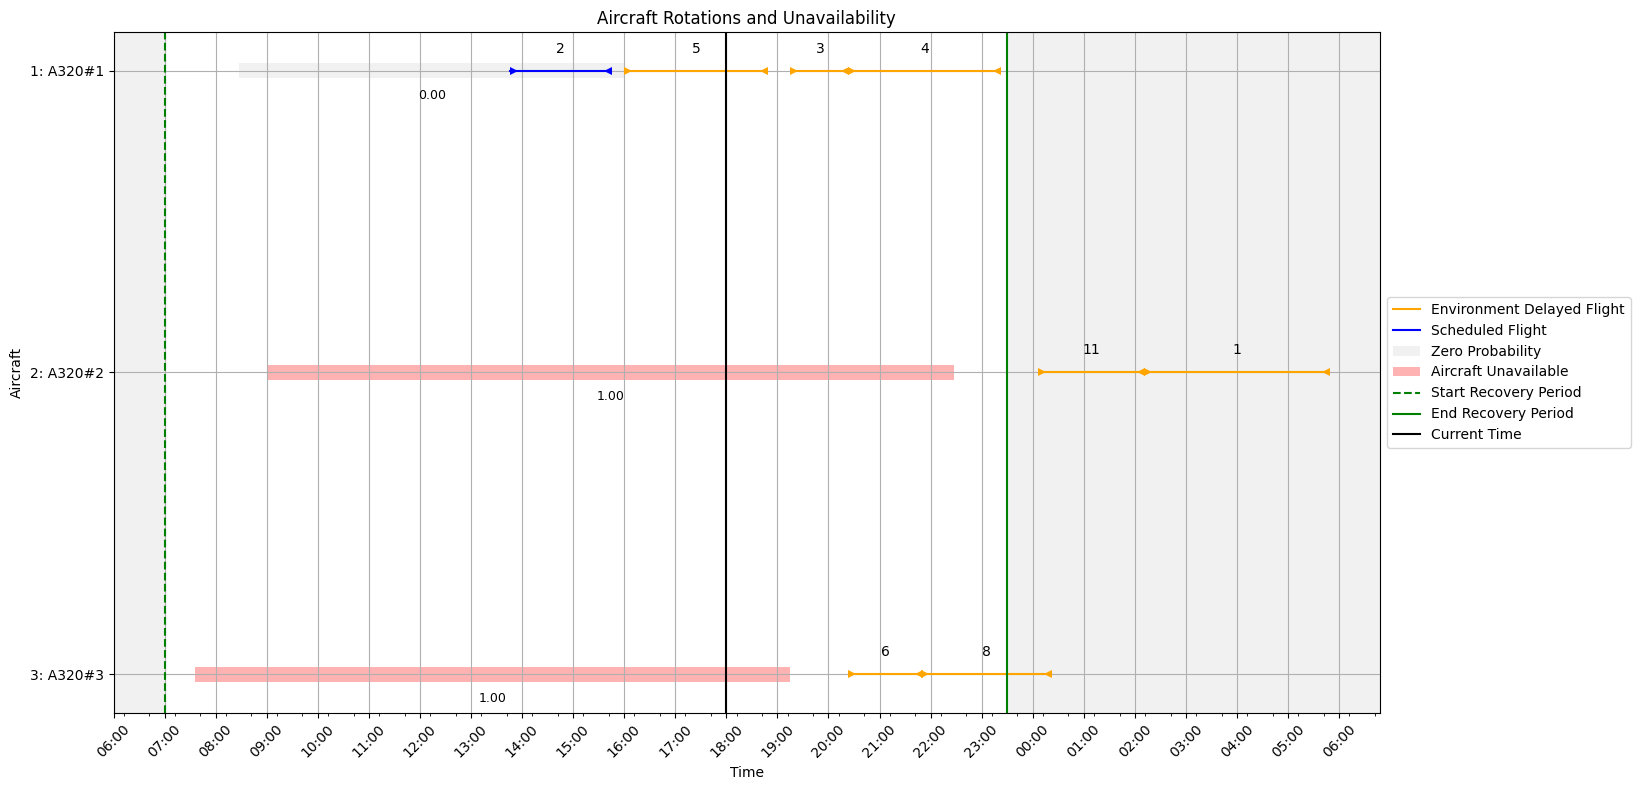

Total Reward: -25580.0


In [2]:
import os
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment_myopic import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter_Proactive

# Run the random agent
def run_random_agent(scenario_folder):
    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)
    # Removed DummyVecEnv wrapping

    # Reset the environment
    obs, info = env.reset()
    if DEBUG_MODE_VISUALIZATION:
        print("Observation keys:", obs.keys())

    done = False
    total_reward = 0
    step_num = 0

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter_Proactive(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )

    # print state nicely
    print_state_nicely_myopic(env.state)


    while not done:
        # Visualize the environment at each step
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.swapped_flights
        environment_delayed_flights = env.environment_delayed_flights
        current_datetime = env.current_datetime

        # Retrieve the updated dictionaries from the environment
        updated_flights_dict = env.flights_dict
        updated_rotations_dict = env.rotations_dict
        updated_alt_aircraft_dict = env.alt_aircraft_dict
        cancelled_flights = env.penalized_cancelled_flights

        if DEBUG_MODE_VISUALIZATION:
            print("Flights Dict:")
            print(updated_flights_dict)
            print("Alt Aircraft Dict:")
            print(updated_alt_aircraft_dict)
            print("Swapped Flights:")
            print(swapped_flights)
            print("Environment Delayed Flights:")
            print(environment_delayed_flights)
            print("Cancelled Flights:")
            print(cancelled_flights)
            print("Unavailabilities:")
            print(env.alt_aircraft_dict)
            print("Uncertain Breakdowns:")
            for key, value in env.uncertain_breakdowns.items():
                print(f"{key}: {value}")
            print("Current Breakdowns:")
            print(env.current_breakdowns)
            print("")

        # Update the StatePlotter's dictionaries with the updated ones
        state_plotter.alt_aircraft_dict = updated_alt_aircraft_dict
        state_plotter.flights_dict = updated_flights_dict
        state_plotter.rotations_dict = updated_rotations_dict

        # Plot the state using the updated dictionaries
        state_plotter.plot_state(
            updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
        )

        # Sample a valid action
        action_index = sample_valid_action(env, obs)  # Get the single action index
        print(f"Action index: {action_index}")


        # Step the environment
        obs, reward, terminated, truncated, info = env.step(action_index)  # Pass the scalar action index

        # Determine if the episode is done
        done = terminated or truncated

        # Accumulate the reward
        total_reward += reward

        # Print action taken and reward
        # print(f"Action taken: Flight {action[0]}, Aircraft {action[1]}, Reward: {reward}")
        # print("")

        step_num += 1

    # Final plot after the simulation ends
    state_plotter.plot_state(
        updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
    )

    print(f"Total Reward: {total_reward}")


def sample_valid_action(env, obs):
    # Extract the action masks for flights and aircraft
    flight_action_mask = obs['action_mask'][0]
    aircraft_action_mask = obs['action_mask'][1]
    
    # Get indices of valid flight actions
    valid_flight_actions = np.where(flight_action_mask == 1)[0]
    # Randomly select a valid flight action
    flight_action = np.random.choice(valid_flight_actions)
    
    # Get indices of valid aircraft actions
    valid_aircraft_actions = np.where(aircraft_action_mask == 1)[0]
    # Randomly select a valid aircraft action
    aircraft_action = np.random.choice(valid_aircraft_actions)
    
    # Map to a single index
    action_index = env.map_action_to_index(flight_action, aircraft_action)
    
    return action_index  # Return the single action index


SCENARIO_FOLDER = "../Data/Testing/1k-3ac-12f-1dis-F/Scenario_01"
# SCENARIO_FOLDER = "../data/Example/Busy-scenario"

# Verify folder exists
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

# Run the random agent
run_random_agent(SCENARIO_FOLDER)
